**Nota** : in caso di dubbi, vedere il codice prova_gridsearch4all

# Preliminary steps

## Libraries

In [225]:
import os, pandas as pd, numpy as np

from scipy.signal import find_peaks

from sklearn.metrics import confusion_matrix, make_scorer, classification_report, jaccard_score, multilabel_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

from matplotlib import pyplot as plt, gridspec

from tabulate import tabulate

from itertools import product

## Get and Analyse the data

In [226]:
# Path to the dataset
folder_path = 'C:/Users/miche/Desktop/Virtual Environment/Preparazione Dataset/Estratti_nuovo'

# Empty dictionary to store the extracted dataframes
extracted = {}

# Extract the dataframes from the csv files
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        extracted[filename] = df

# Print the number of extracted dataframes and their names
print('Extracted {} dataframes'.format(len(extracted)))
print('Dataframes: {}'.format(extracted.keys()))
print("")

# Concatenate all the dataframes into a single one
df = pd.concat(extracted.values(), ignore_index=True)
df = df.drop(['Unnamed: 0', 'Linear_x', 'Linear_y', 'Linear_z', 'Angular_x', 'Angular_y', 'Angular_z'], axis=1)

# Print infos on concatenated dataframe
print('Concatenated dataframe infos:')
print("")
print('Shape: {}'.format(df.shape))
print('Columns: {}'.format(df.columns))
print("")
print('Number of each label: {}'.format(df['Classe sx'].value_counts()))
print("")
print('Number of each label: {}'.format(df['Classe dx'].value_counts()))


Extracted 39 dataframes
Dataframes: dict_keys(['06_appoggi_manodx.csv', '06_appoggi_manosx.csv', '06_carezze_ab_destra.csv', '06_carezze_ab_esternedx.csv', '06_carezze_ab_esternesx.csv', '06_carezze_ab_mono.csv', '06_carezze_ab_mono2.csv', '06_carezze_ab_sinistra.csv', '06_carezze_ab_sinistra2.csv', '06_carezze_ba_destra.csv', '06_carezze_ba_sinistra.csv', '06_carezze_dxsx.csv', '06_carezze_dxsx2.csv', '06_carezze_sxdx.csv', '06_carezze_sxdx2.csv', '06_carezze_tripla_destra.csv', '06_carezze_tripla_sinistra.csv', '06_pugni.csv', '06_sberla.csv', '06_solletico.csv', '06_taptaps.csv', '07_dito.csv', '07_pugni.csv', '07_sberle.csv', '07_sberle_daterra.csv', '07_solletico.csv', '07_spinte.csv', '07_taptap.csv', '25_appoggio_leggero.csv', '25_carezze_ab.csv', '25_carezze_ba.csv', '25_carezze_dx.csv', '25_carezze_semplici.csv', '25_carezze_sx.csv', '25_carezze_trasv.csv', '25_pugno.csv', '25_solletico2.csv', '25_spinta.csv', '25_taptap.csv'])

Concatenated dataframe infos:

Shape: (115178, 7

In [227]:
# Una prova - Concatenazione di 3 dataset
prova = {'06_pugni.csv': extracted['06_pugni.csv'], '06_solletico.csv': extracted['06_solletico.csv'], '07_dito.csv': extracted['07_dito.csv']}
prova_concat = pd.concat([prova['06_pugni.csv'], prova['06_solletico.csv'], prova['07_dito.csv']], ignore_index=True)
print("Len of prova_concat and all the datasets inside:",len(prova_concat), len(prova['06_pugni.csv']), len(prova['06_solletico.csv']), len(prova['07_dito.csv']))
print("Number of each label in prova_concat:",prova_concat['Classe sx'].value_counts())
print("")

Len of prova_concat and all the datasets inside: 6791 2568 3063 1160
Number of each label in prova_concat: Classe sx
No tocco     4867
Solletico    1383
Pugno         350
Spinta        191
Name: count, dtype: int64



## Classification function

secondo me c'è errore nella funzione, nel senso che la window è di 33, però il pugno legge solo ed esclusivamente il primo punto toccato mentre gli altri necessitano di tutta la finestra. Da inserire il pugno

In [228]:
class ClassifierGlobal(BaseEstimator, ClassifierMixin):
    def __init__(self, sensor,sliding_window,th_cip,th_cif,win_cif,th_spinta_up,th_spinta_down,dist_spinta_min,dist_spinta_max,th_solletico,n_solletico):
        #### Parameters ####


        ## Generali ##
        self.sensor = sensor # Sensor to use for the classification
        self.sliding_window = sliding_window # Sliding window for the classification

        ## Colpo Istantaneo ##
        self.th_cip, self.th_cif, self.win_cif = th_cip, th_cif, win_cif # Threshold pressure, threshold flex, window for the flex of the Colpo Istantaneo

        ## Spinta ##
        self.th_spinta_up, self.th_spinta_down, self.dist_spinta_min, self.dist_spinta_max = th_spinta_up, th_spinta_down, dist_spinta_min, dist_spinta_max # Prominance thresholds (Up and Down), min and max distance between peaks for the Spinta

        ## Solletico ##
        self.th_solletico, self.n_solletico = th_solletico, n_solletico # Prominance threshold for peaks, number of peaks for the Solletico

    def fit(self, X, y):
        # Fit the classifier: the classes are assumed to be the one in the y array
        self.classes_ = np.unique(y)
        return self
    
    def predict(self, X):
        # Predict the labels for the input X array: initialize the predictions array with the 'No tocco' label
        predictions = ['No tocco']*len(X)


        # Initialize the arrays for the classification
        window_pressure, window_flex = [], []
        array_up_spinta, array_down_spinta = [], []

        # For each sample in the input array
        for index,value in enumerate(X['Pressure']):

            # Append the values to the arrays
            window_pressure.append(value)
            window_flex.append(X[self.sensor].iloc[index])
            
            if len(window_pressure) == self.sliding_window:
            
            #### Colpi Istantanei ####
                
                '''
                if value > self.th_pugno:
                    predictions[index-3:index+4] = ['Pugno'] * 7
                # Istantanei
                '''
                
                if any(x > 2 for x in window_pressure): # self.th_pugno = 7 
                    diff = np.ptp(X[self.sensor].iloc[index-self.win_cif:index+self.win_cif+1])
                    if diff > 7500: #self.th_is = 7500
                        predictions[index-3:index+4] = ['Pugno'] * 7
                
            #### Touch with window ####
            
                # Spinta
                neg_window_pressure = [-x for x in window_pressure]

                peaks_up_spinta, _ = find_peaks(window_pressure, prominence=self.th_spinta_up)
                peaks_down_spinta, _ = find_peaks(neg_window_pressure, prominence=self.th_spinta_down)

                peaks_indices_up_spinta = index - (self.sliding_window - 1) + peaks_up_spinta
                peaks_indices_down_spinta = index - (self.sliding_window - 1) + peaks_down_spinta

                array_up_spinta = np.unique(np.append(array_up_spinta, peaks_indices_up_spinta)).astype(int)
                array_down_spinta = np.unique(np.append(array_down_spinta, peaks_indices_down_spinta)).astype(int)
                valid_pairs = [(m, n) for m, n in product(array_up_spinta, array_down_spinta) if n - m > self.dist_spinta_min and n - m < self.dist_spinta_max]
                for m, n in valid_pairs:
                    predictions[m:n+1] = ['Spinta'] * (n-m+1)  

                
                # Solletico
                peaks_solletico, _ = find_peaks(window_flex, prominence=self.th_solletico)
                peaks_indices_solletico = index - (self.sliding_window - 1) + peaks_solletico
                if len(peaks_indices_solletico) > self.n_solletico:
                    for k in peaks_indices_solletico:
                        predictions[k-3:k+4] = ['Solletico'] * 7

                
                
                # Remove the first element of the arrays
                window_pressure.pop(0)
                window_flex.pop(0)
        
        return np.array(predictions[:len(X)])

# Grid Search - Classe sx

## Initialization

In [229]:
#### Data and target ####
data = prova_concat[['Time', 'Flexsx', 'Flexdx', 'Pressure']] #data = df[['Time', 'Flexsx', 'Flexdx', 'Pressure']]
target = prova_concat[['Classe sx']] #target = df[['Classe sx']]

#### Splitting ####
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.9, random_state=42, shuffle=False)

#### Parameters ####
param_grid_multilabel = {'sensor': ['Flexsx'],
                        'sliding_window': [33],
                        'th_cip': [7], 'th_cif': [7500], 'win_cif': [1],
                        'th_spinta_up': [0.75], 'th_spinta_down': [0.5], 'dist_spinta_min': [3], 'dist_spinta_max': [12],
                        'th_solletico': [1300],'n_solletico': [5]}

#### Scoring function ####
scoring_function = make_scorer(jaccard_score, average='weighted', labels=np.unique(target), zero_division=0)

#### Model ####         
classifier = ClassifierGlobal(sensor = 'Flexsx', sliding_window = 33, th_cip = 7, th_cif = 7500, win_cif = 1, th_spinta_up = 0.75, th_spinta_down = 0.5, dist_spinta_min = 3, dist_spinta_max = 12, th_solletico = 1300, n_solletico = 5)

In [230]:
#### Infos about the GridSearch ####
print('GridSearch infos:')
print("Label to classify: {}".format(np.unique(target)))
print("")
print("Number of labels in y_train:",y_train['Classe sx'].value_counts())
print("")
print("Number of labels in y_test:",y_test['Classe sx'].value_counts())
print("")


GridSearch infos:
Label to classify: ['No tocco' 'Pugno' 'Solletico' 'Spinta']

Number of labels in y_train: Classe sx
No tocco    588
Pugno        91
Name: count, dtype: int64

Number of labels in y_test: Classe sx
No tocco     4279
Solletico    1383
Pugno         259
Spinta        191
Name: count, dtype: int64



## GridSearchCV

In [ ]:
gs_multi_label = GridSearchCV(classifier, param_grid_multilabel, scoring = scoring_function, cv=5)
gs_multi_label.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=ClassifierGlobal(dist_spinta_max=12, dist_spinta_min=3,
                                        n_solletico=5, sensor='Flexsx',
                                        sliding_window=33, th_cif=7500,
                                        th_cip=7, th_solletico=1300,
                                        th_spinta_down=0.5, th_spinta_up=0.75,
                                        win_cif=1),
             param_grid={'dist_spinta_max': [12], 'dist_spinta_min': [3],
                         'n_solletico': [5], 'sensor': ['Flexsx'],
                         'sliding_window': [33], 'th_cif': [7500],
                         'th_cip': [7], 'th_solletico': [1300],
                         'th_spinta_down': [0.5], 'th_spinta_up': [0.75],
                         'win_cif': [1]},
             scoring=make_scorer(jaccard_score, average=weighted, labels=['No tocco' 'Pugno' 'Solletico' 'Spinta'], zero_division=0))

## Results

In [ ]:
results = gs_multi_label.cv_results_
table_results = {key: results[key] for key in ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']}
print('Best estimator:')
print('- Parameters: {}'.format(gs_multi_label.best_params_)) 
print('- Score: {}'.format(gs_multi_label.best_score_))
print("")
print('Table with the results of the grid search: \n {}'.format(tabulate(table_results, headers='keys')))

Best estimator:
- Parameters: {'dist_spinta_max': 12, 'dist_spinta_min': 3, 'n_solletico': 5, 'sensor': 'Flexsx', 'sliding_window': 33, 'th_cif': 7500, 'th_cip': 7, 'th_solletico': 1300, 'th_spinta_down': 0.5, 'th_spinta_up': 0.75, 'win_cif': 1}
- Score: 0.8914169709437711

Table with the results of the grid search: 
 params                                                                                                                                                                                                                     mean_test_score    std_test_score    rank_test_score
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------------  ----------------  -----------------
{'dist_spinta_max': 12, 'dist_spinta_min': 3, 'n_solletico': 5, 'sensor': 'Flexsx', 'sliding_window': 33, 'th_cif': 7500, 'th_cip': 7, '

In [ ]:
report = classification_report(y_test, gs_multi_label.predict(X_test), output_dict = False, zero_division = 0)
print('Classification report of the prediction: \n {}'.format(report))

Classification report of the prediction: 
               precision    recall  f1-score   support

    No tocco       0.95      0.92      0.93      4279
       Pugno       0.63      0.91      0.74       259
   Solletico       0.85      0.87      0.86      1383
      Spinta       0.97      1.00      0.99       191

    accuracy                           0.91      6112
   macro avg       0.85      0.92      0.88      6112
weighted avg       0.91      0.91      0.91      6112



## Grafici Classe sx - Importanti

In [ ]:
# Find the indices of the predictions
pugno = np.where(gs_multi_label.predict(X_test) == 'Pugno')
sberla = np.where(gs_multi_label.predict(X_test) == 'Sberla')
spinta = np.where(gs_multi_label.predict(X_test) == 'Spinta')
solletico = np.where(gs_multi_label.predict(X_test) == 'Solletico')

Where pugno is predicted but actual is spinta: (array([], dtype=int64),)
Where spinta is predicted but actual is pugno: (array([1399, 1400, 1401, 1402], dtype=int64),)


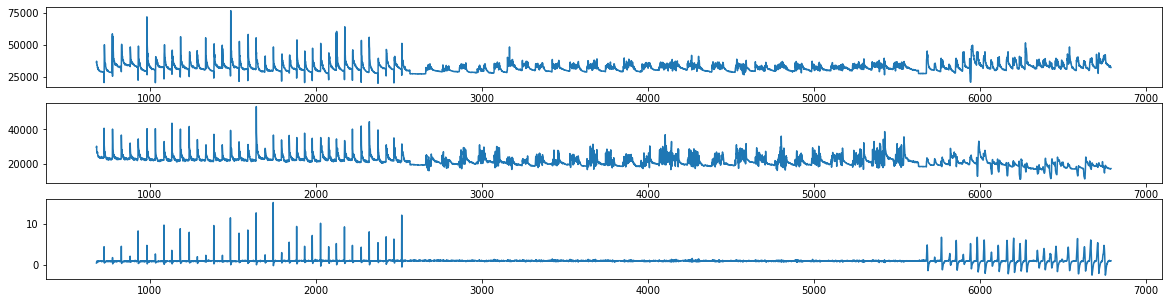

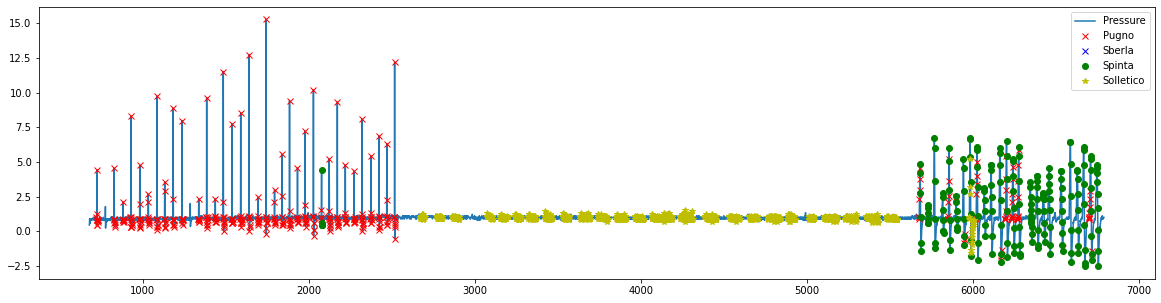

In [ ]:
# Plot the values of the signals
fig,axes = plt.subplots(3,1, figsize=(20,5))
axes[0].plot(X_test['Flexsx'])
axes[1].plot(X_test['Flexdx'])
axes[2].plot(X_test['Pressure'])

# Plot the points where the predictions are made
fig,axes = plt.subplots(1,1, figsize=(20,5))
axes.plot(X_test['Pressure'])
axes.plot(X_test.iloc[pugno]['Pressure'], 'rx')
axes.plot(X_test.iloc[sberla]['Pressure'], 'bx')
axes.plot(X_test.iloc[spinta]['Pressure'], 'go')
axes.plot(X_test.iloc[solletico]['Pressure'], 'y*')
axes.legend(['Pressure', 'Pugno', 'Sberla', 'Spinta', 'Solletico'])

# Print the index where an error occurs
print("Where pugno is predicted but actual is spinta:",np.where((gs_multi_label.predict(X_test) == 'Pugno') & (y_test['Classe sx'] == 'Spinta')))
print("Where spinta is predicted but actual is pugno:",np.where((gs_multi_label.predict(X_test) == 'Spinta') & (y_test['Classe sx'] == 'Pugno')))

# Grid Search - Classe Dx

In [ ]:
#### Data and target ####
data = prova_concat[['Time', 'Flexsx', 'Flexdx', 'Pressure']] #data = df[['Time', 'Flexsx', 'Flexdx', 'Pressure']]
target = prova_concat[['Classe dx']] #target = df[['Classe sx']]

#### Splitting ####
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.9, random_state=42, shuffle=False)

#### Parameters ####
param_grid_multilabel_dx = {'sensor': ['Flexdx'],
                        'sliding_window': [33],
                        'th_cip': [7], 'th_cif': [7500], 'win_cif': [1],
                        'th_spinta_up': [0.75], 'th_spinta_down': [0.5], 'dist_spinta_min': [3], 'dist_spinta_max': [12],
                        'th_solletico': [1300],'n_solletico': [5]}

#### Scoring function ####
scoring_function = make_scorer(jaccard_score, average='weighted', labels=np.unique(target), zero_division=0)

#### Model ####         
classifier = ClassifierGlobal(sensor = 'Flexdx', sliding_window = 33, th_cip = 7, th_cif = 7500, win_cif = 1, th_spinta_up = 0.75, th_spinta_down = 0.5, dist_spinta_min = 3, dist_spinta_max = 12, th_solletico = 1300, n_solletico = 5)

In [ ]:
#### Infos about the GridSearch ####
print('GridSearch infos:')
print("Label to classify: {}".format(np.unique(target)))
print("")
print("Number of labels in y_train:",y_train['Classe dx'].value_counts())
print("")
print("Number of labels in y_test:",y_test['Classe dx'].value_counts())
print("")


GridSearch infos:
Label to classify: ['No tocco' 'Pugno' 'Solletico' 'Spinta']

Number of labels in y_train: Classe dx
No tocco    588
Pugno        91
Name: count, dtype: int64

Number of labels in y_test: Classe dx
No tocco     4279
Solletico    1383
Pugno         259
Spinta        191
Name: count, dtype: int64



## GridSearchCV

In [ ]:
gs_multi_label_dx = GridSearchCV(classifier, param_grid_multilabel_dx, scoring = scoring_function, cv=5)
gs_multi_label_dx.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=ClassifierGlobal(dist_spinta_max=12, dist_spinta_min=3,
                                        n_solletico=5, sensor='Flexdx',
                                        sliding_window=33, th_cif=7500,
                                        th_cip=7, th_solletico=1300,
                                        th_spinta_down=0.5, th_spinta_up=0.75,
                                        win_cif=1),
             param_grid={'dist_spinta_max': [12], 'dist_spinta_min': [3],
                         'n_solletico': [5], 'sensor': ['Flexdx'],
                         'sliding_window': [33], 'th_cif': [7500],
                         'th_cip': [7], 'th_solletico': [1300],
                         'th_spinta_down': [0.5], 'th_spinta_up': [0.75],
                         'win_cif': [1]},
             scoring=make_scorer(jaccard_score, average=weighted, labels=['No tocco' 'Pugno' 'Solletico' 'Spinta'], zero_division=0))

## Results

In [ ]:
results_dx = gs_multi_label_dx.cv_results_
table_results_dx = {key: results_dx[key] for key in ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']}
print('Best estimator:')
print('- Parameters: {}'.format(gs_multi_label_dx.best_params_)) 
print('- Score: {}'.format(gs_multi_label_dx.best_score_))
print("")
print('Table with the results of the grid search: \n {}'.format(tabulate(table_results_dx, headers='keys')))

Best estimator:
- Parameters: {'dist_spinta_max': 12, 'dist_spinta_min': 3, 'n_solletico': 5, 'sensor': 'Flexdx', 'sliding_window': 33, 'th_cif': 7500, 'th_cip': 7, 'th_solletico': 1300, 'th_spinta_down': 0.5, 'th_spinta_up': 0.75, 'win_cif': 1}
- Score: 0.9060153394119748

Table with the results of the grid search: 
 params                                                                                                                                                                                                                     mean_test_score    std_test_score    rank_test_score
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------------  ----------------  -----------------
{'dist_spinta_max': 12, 'dist_spinta_min': 3, 'n_solletico': 5, 'sensor': 'Flexdx', 'sliding_window': 33, 'th_cif': 7500, 'th_cip': 7, '

In [ ]:
report = classification_report(y_test, gs_multi_label_dx.predict(X_test), output_dict = False, zero_division = 0)
print('Classification report of the prediction: \n {}'.format(report))

Classification report of the prediction: 
               precision    recall  f1-score   support

    No tocco       0.91      0.96      0.94      4279
       Pugno       0.80      0.83      0.82       259
   Solletico       0.90      0.74      0.81      1383
      Spinta       0.97      1.00      0.99       191

    accuracy                           0.91      6112
   macro avg       0.90      0.88      0.89      6112
weighted avg       0.91      0.91      0.90      6112



## Grafici Classe sx - Importanti

In [ ]:
# Find the indices of the predictions
pugnodx = np.where(gs_multi_label_dx.predict(X_test) == 'Pugno')
sberladx = np.where(gs_multi_label_dx.predict(X_test) == 'Sberla')
spintadx = np.where(gs_multi_label_dx.predict(X_test) == 'Spinta')
solleticodx = np.where(gs_multi_label_dx.predict(X_test) == 'Solletico')

Where pugno is predicted but actual is spinta: (array([], dtype=int64),)
Where spinta is predicted but actual is pugno: (array([1399, 1400, 1401, 1402], dtype=int64),)


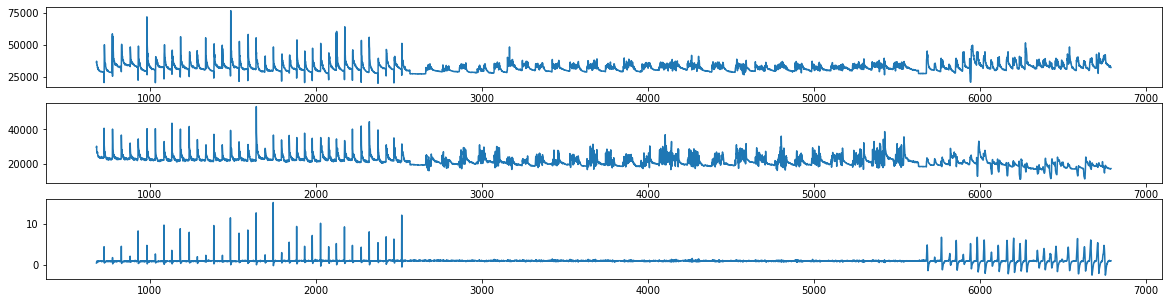

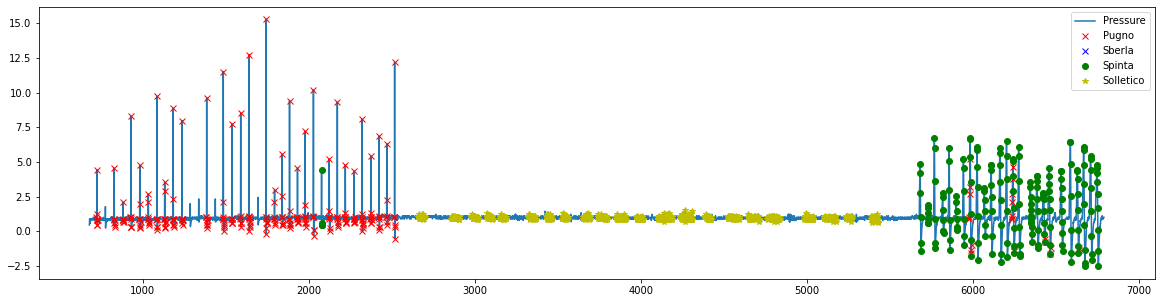

In [ ]:
# Plot the values of the signals
fig,axes = plt.subplots(3,1, figsize=(20,5))
axes[0].plot(X_test['Flexsx'])
axes[1].plot(X_test['Flexdx'])
axes[2].plot(X_test['Pressure'])

# Plot the points where the predictions are made
fig,axes = plt.subplots(1,1, figsize=(20,5))
axes.plot(X_test['Pressure'])
axes.plot(X_test.iloc[pugnodx]['Pressure'], 'rx')
axes.plot(X_test.iloc[sberladx]['Pressure'], 'bx')
axes.plot(X_test.iloc[spintadx]['Pressure'], 'go')
axes.plot(X_test.iloc[solleticodx]['Pressure'], 'y*')
axes.legend(['Pressure', 'Pugno', 'Sberla', 'Spinta', 'Solletico'])

# Print the index where an error occurs
print("Where pugno is predicted but actual is spinta:",np.where((gs_multi_label.predict(X_test) == 'Pugno') & (y_test['Classe dx'] == 'Spinta')))
print("Where spinta is predicted but actual is pugno:",np.where((gs_multi_label.predict(X_test) == 'Spinta') & (y_test['Classe dx'] == 'Pugno')))

# Extra - Confusion matrix

<ipython-input-210-f4e6e52986f1>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels4cm)
<ipython-input-210-f4e6e52986f1>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(labels4cm)
<ipython-input-210-f4e6e52986f1>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[len(cm)].set_xticklabels(label_to_classify)
<ipython-input-210-f4e6e52986f1>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[len(cm)].set_yticklabels(label_to_classify)


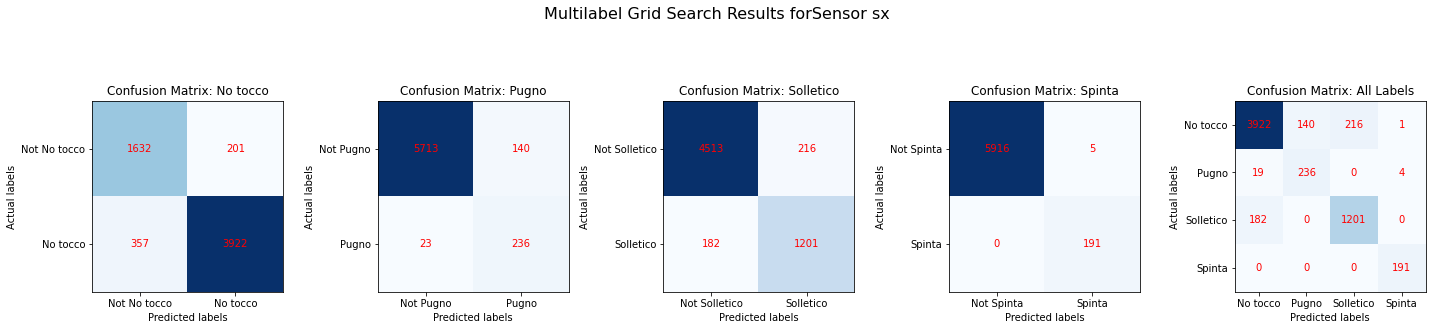

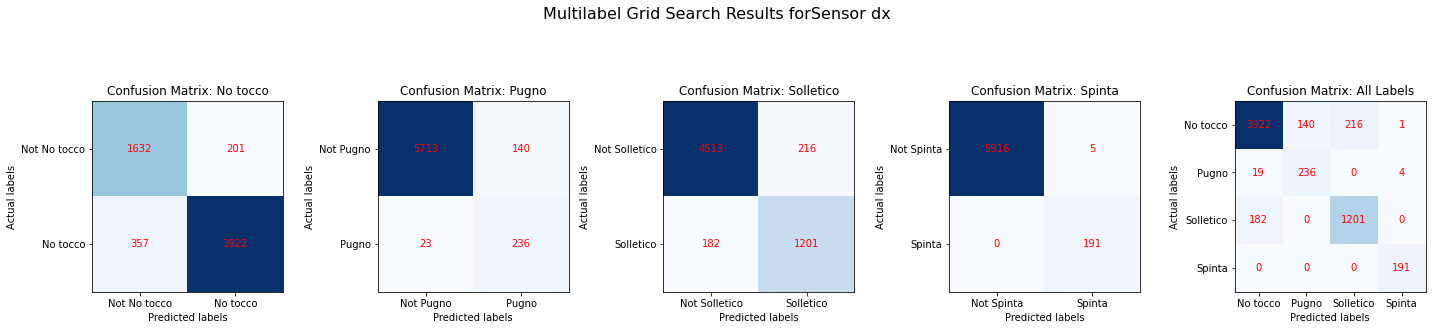

In [ ]:
### Confusion Matrix
#%%capture --no-display

label_to_classify = np.unique(target)

cm = multilabel_confusion_matrix(y_test, gs_multi_label.predict(X_test), labels=np.unique(target))
confusionmatrix = confusion_matrix(y_test, gs_multi_label.predict(X_test), labels=np.unique(target))

cm_dx = multilabel_confusion_matrix(y_test, gs_multi_label_dx.predict(X_test), labels=np.unique(target))
confusionmatrix_dx = confusion_matrix(y_test, gs_multi_label_dx.predict(X_test), labels=np.unique(target))


for iii in ['Sensor sx', 'Sensor dx']:
    fig, ax = plt.subplots(1, 1+len(cm), figsize=(5*len(cm), 5))
    fig.suptitle('Multilabel Grid Search Results for' + iii, fontsize=16)
    for i in range(len(cm)):
        labels4cm = np.array(['Not '+ label_to_classify[i], label_to_classify[i]])

        ax[i].set_title('Confusion Matrix: '+ label_to_classify[i])
        ax[i].imshow(cm[i], cmap='Blues')
        ax[i].set_xlabel('Predicted labels')
        ax[i].set_ylabel('Actual labels')
        ax[i].set_xticklabels(labels4cm)
        ax[i].set_yticklabels(labels4cm)
        ax[i].xaxis.set(ticks=np.arange(len(labels4cm)))
        ax[i].yaxis.set(ticks=np.arange(len(labels4cm)))
        for k in range(len(labels4cm)):
            for j in range(len(labels4cm)):
                ax[i].text(j, k, cm[i][k, j], ha='center', va='center', color='red')

    ax[len(cm)].set_title('Confusion Matrix: All Labels')
    ax[len(cm)].imshow(confusionmatrix, cmap='Blues')
    ax[len(cm)].set_xlabel('Predicted labels')
    ax[len(cm)].set_ylabel('Actual labels')
    ax[len(cm)].set_xticklabels(label_to_classify)
    ax[len(cm)].set_yticklabels(label_to_classify)
    ax[len(cm)].xaxis.set(ticks=np.arange(len(label_to_classify)))
    ax[len(cm)].yaxis.set(ticks=np.arange(len(label_to_classify)))
    for k in range(len(label_to_classify)):
        for j in range(len(label_to_classify)):
            ax[len(cm)].text(j, k, confusionmatrix[k, j], ha='center', va='center', color='red')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
